In [137]:
import csv
import numpy as np
import matplotlib.pyplot as plt
import tools as tools

policy: str = "SM"
dataset: str = "D5"
fileToAccess: str = ("../../data/archives/datasets/" + policy + "_" + dataset + "/range.csv")
sampleStepSize: int = 1300 # 60
startIndex: int = 0

sm_color:str = "#7b2cbf"
ep_color:str = "#e63946"

target1: float = 32
target2: float = 11
target3: float = 51
target4: float = 70

timesteps:list[int] = []

In [138]:
def graphRangeCSV(fileToAccess:str) -> None:
    rmax: list[float] = []
    rmin: list[float] = []
    ravg: list[float] = []
    with open(fileToAccess) as f:
        plots = csv.reader(f, delimiter=';')
        next(plots)
        for i, row in enumerate(plots):
            if i < startIndex: continue
            if i % sampleStepSize !=0: continue
            timesteps.append(int(row[0]))
            rmax.append(float(row[1]))
            rmin.append(float(row[2]))
            ravg.append(float(row[3]))
    plt.xlabel("timestep")
    plt.ylabel("reward (dollars)")
    plt.title("SoftMax" if policy == "SM"  else "Epsilon-Greedy")
    plt.grid(linestyle="--", linewidth=0.5)
    plt.ylim([-150, 170])
    plt.plot(timesteps, ravg, sm_color if policy == "SM"  else ep_color)
    plt.fill_between(timesteps, rmax, rmin, color=sm_color if policy == "SM"  else ep_color, alpha=0.4)

In [139]:
def graphLossTime(fileToAccess:str, epochSize: int, episodeSize: int) -> None:
    target1: float = 32
    target2: float = 11
    target3: float = 51
    target4: float = 70
    timestepsChunk: int = epochSize * episodeSize
    loss: list[float] = []
    with open(fileToAccess) as f:
        plots = csv.reader(f, delimiter=';')
        next(plots)
        for i, row in enumerate(plots):
            target: float
            if (i < timestepsChunk): target = target1
            elif (i < 2* timestepsChunk): target = target2
            elif (i < 3*timestepsChunk): target = target3
            elif (i <= 4*timestepsChunk): target = target4
            else: target = target1
            if i < startIndex: continue
            if i % sampleStepSize !=0: continue
            timesteps.append(int(row[0]))
            loss.append(tools.calculateLoss(float(row[3]), target))
    normalisedLossDistr: list[float] = tools.normaliseDistr(loss)
    plt.xlabel("timestep")
    plt.ylabel("loss")
    plt.title("SoftMax" if policy == "SM"  else "Epsilon-Greedy")
    plt.grid(linestyle="--", linewidth=0.5)
    plt.xlim([0, max(timesteps)+0.1])
    plt.ylim([0, max(normalisedLossDistr)+0.1])
    plt.plot(timesteps, normalisedLossDistr, sm_color if policy == "SM"  else ep_color)
    print(tools.findMeanSquaredError(normalisedLossDistr))

def computeReconvTimes(fileToAccess:str, epochSize: int, episodeSize: int) -> None:
    lossThreshold: int = 20
    timeThreshold: int = 250
    timestepsChunk: int = epochSize * episodeSize
    rew1: list[float] = []
    rew2: list[float] = []
    rew3: list[float] = []
    rew4: list[float] = []
    durations: list = []
    with open(fileToAccess) as f:
        plots = csv.reader(f, delimiter=';')
        next(plots)
        for i, row in enumerate(plots):
            if (i < timestepsChunk):
                rew1.append(float(row[3]))
            elif (timestepsChunk<i < 2* timestepsChunk):
                rew2.append(float(row[3]))
            elif (2* timestepsChunk <i < 3*timestepsChunk):
                rew3.append(float(row[3]))
            elif (3*timestepsChunk<i < 4*timestepsChunk):
                rew4.append(float(row[3]))
            else:
                timesteps.append(int(row[0]))
                if (i == timestepsChunk):
                    rew1.append(float(row[3]))
                    durations.append(tools.findReconvergenceTime(rew1, target1, lossThreshold, timeThreshold))
                elif (i == 2 * timestepsChunk):
                    rew2.append(float(row[3]))
                    durations.append(tools.findReconvergenceTime(rew2, target2, lossThreshold, timeThreshold))
                elif (i == 3* timestepsChunk):
                    rew3.append(float(row[3]))
                    durations.append(tools.findReconvergenceTime(rew3, target3, lossThreshold, timeThreshold))
                elif (i == 4* timestepsChunk):
                    rew4.append(float(row[3]))
                    durations.append(tools.findReconvergenceTime(rew4, target4, lossThreshold, timeThreshold))
            # if i < startIndex: continue
            # if i % sampleStepSize !=0: continue
    # normalisedLossDistr: list[float] = normaliseLossDistr(loss)
    print(durations)

def graphLossDistr(fileToAccess:str, epochSize: int, episodeSize: int) -> None:
    timestepsChunk: int = epochSize * episodeSize
    loss: list[float] = []
    with open(fileToAccess) as f:
        plots = csv.reader(f, delimiter=';')
        next(plots)
        for i, row in enumerate(plots):
            target: float
            if (i < timestepsChunk): target = target1
            elif (i < 2* timestepsChunk): target = target2
            elif (i < 3*timestepsChunk): target = target3
            elif (i <= 4*timestepsChunk): target = target4
            else: target = target1
            if i < startIndex: continue
            if i % sampleStepSize !=0: continue
            timesteps.append(int(row[0]))
            loss.append(tools.calculateLoss(float(row[3]), target))
    normalisedLossDistr: list[float] = tools.normaliseDistr(loss)
    normalisedTimesteps: list[float] = tools.normaliseDistr([float(x) for x in timesteps])
    normalisedSortedLossDistr: list[float] = tools.sortLossDistr(normalisedLossDistr)
    cvar:float = tools.computeConditionalVAR(normalisedSortedLossDistr, normalisedTimesteps, 95)
    print(cvar)
    plt.xlabel("quantile")
    plt.ylabel("loss")
    plt.title("SoftMax" if policy == "SM"  else "Epsilon-Greedy")
    plt.grid(linestyle="--", linewidth=0.5)
    plt.xlim([0, max(normalisedTimesteps)+0.1])
    plt.ylim([0, max(normalisedSortedLossDistr)+0.1])
    plt.plot(normalisedTimesteps, normalisedSortedLossDistr, sm_color if policy == "SM"  else ep_color)


In [140]:
# graphRangeCSV(fileToAccess)
# computeReconvTimes(fileToAccess, 1500, 40)

0.7455059687786956


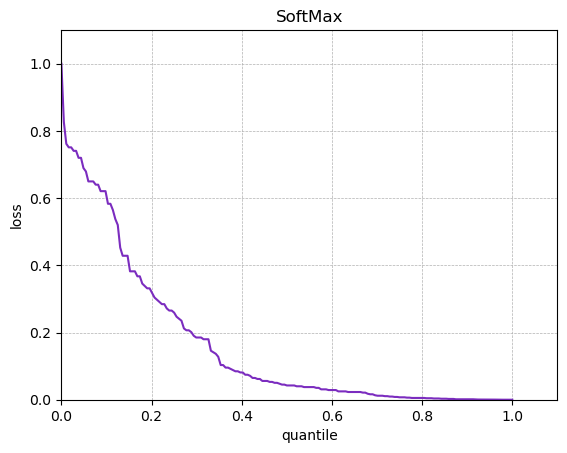

In [141]:
graphLossDistr(fileToAccess, 1500, 40)

In [142]:
# graphLossTime(fileToAccess, 1500, 40)

In [143]:
# plt.scatter(x=timesteps, y=rmax, color="g")



""" z = np.polyfit(timesteps, ravg, 4)
p = np.poly1d(z)
plt.plot(timesteps, p(timesteps), "g") """


' z = np.polyfit(timesteps, ravg, 4)\np = np.poly1d(z)\nplt.plot(timesteps, p(timesteps), "g") '